<a href="https://colab.research.google.com/github/Fabahmed12/Data_Science_Projects/blob/main/Final_portfolio_otimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [ ]:
predicted_data = pd.read_csv('PPS (2).csv', index_col=0, parse_dates=True)
predicted_returns = predicted_data.pct_change().dropna()

<ipython-input-65-ffaf56cd6c35>:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  predicted_returns = predicted_data.pct_change().dropna()


In [ ]:
clusters_df = pd.read_csv('company_metrics (1).csv')
company_clusters = clusters_df.set_index('Company')['Cluster'].to_dict()

In [ ]:
actual_data = pd.read_csv('Actual stock prices.csv', header = 1, index_col=0, parse_dates=True)  # <- Your actual prices file
actual_returns = actual_data.pct_change().dropna()

In [ ]:

print("Predicted Price Columns:", list(predicted_data.columns))
print("Actual Price Columns:", list(actual_data.columns))


Predicted Price Columns: ['PP AIRLINK ', 'PP AVN', 'PP HUM ', 'PP MDTL', 'PP NETSOL ', 'PP OCTOPUS ', 'PP PAKD', 'PP PTC', 'PP STL', 'PP SYM', 'PP TPL', 'PP TPLT', 'PP SYS', 'PP TRG', 'PP TL', 'PP WCT', 'PP AHCL', 'PP FFC', 'PP FATF', 'PP EFERT', 'PP NRL', 'PP CYNERGY', 'PP PRL', 'PP ATRL', 'PP PPL', 'PP PKOL', 'PP OGEC', 'PP MARI']
Actual Price Columns: ['AIRLINK Actual Price', 'AVN Actual Price', 'HUM Actual Price', 'MDTL Actual Price', 'NETSOL Actual Price', 'OCTOPUS Actual Price', 'PAKD Actual Price', 'PTC Actual Price', 'STL Actual Price', 'SYM Actual Price', 'TPL Actual Price', 'TPLT Actual Price', 'SYS Actual Price', 'TRG Actual Price', 'TL Actual Price', 'WCT Actual Price', 'AHCL Actual Price', 'FFC Actual Price', 'FATF Actual Price', 'EFERT Actual Price', 'NRL Actual Price', 'CYNERGY Actual Price', 'PRL Actual Price', 'ATRL Actual Price', 'PPL Actual Price', 'PKOL Actual Price', 'OGEC Actual Price', 'MARI Actual Price']


In [ ]:
# Clean predicted price column names
predicted_data.columns = predicted_data.columns.str.replace('PP ', '', regex=False).str.strip().str.upper()

# Clean actual price column names
actual_data.columns = actual_data.columns.str.replace(' Actual Price', '', regex=False).str.strip().str.upper()


In [ ]:
common_cols = list(set(predicted_data.columns) & set(actual_data.columns))


In [ ]:
# --- Load & Clean Data ---
predicted_data = pd.read_csv('PPS (2).csv', index_col=0, parse_dates=True)
actual_data = pd.read_csv('Actual stock prices.csv', index_col=0, header=1, parse_dates=True)

# Clean and standardize column names
predicted_data.columns = predicted_data.columns.str.replace('PP ', '', regex=False).str.strip().str.upper()
actual_data.columns = actual_data.columns.str.replace(' Actual Price', '', regex=False).str.strip().str.upper()

# Now compute returns
predicted_returns = predicted_data.pct_change().dropna()
actual_returns = actual_data.pct_change().dropna()

# Check if columns are now matching
print("Predicted:", predicted_returns.columns.tolist())
print("Actual   :", actual_returns.columns.tolist())


Predicted: ['AIRLINK', 'AVN', 'HUM', 'MDTL', 'NETSOL', 'OCTOPUS', 'PAKD', 'PTC', 'STL', 'SYM', 'TPL', 'TPLT', 'SYS', 'TRG', 'TL', 'WCT', 'AHCL', 'FFC', 'FATF', 'EFERT', 'NRL', 'CYNERGY', 'PRL', 'ATRL', 'PPL', 'PKOL', 'OGEC', 'MARI']
Actual   : ['AIRLINK', 'AVN', 'HUM', 'MDTL', 'NETSOL', 'OCTOPUS', 'PAKD', 'PTC', 'STL', 'SYM', 'TPL', 'TPLT', 'SYS', 'TRG', 'TL', 'WCT', 'AHCL', 'FFC', 'FATF', 'EFERT', 'NRL', 'CYNERGY', 'PRL', 'ATRL', 'PPL', 'PKOL', 'OGEC', 'MARI']


<ipython-input-82-c0e7ac18350b>:10: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  predicted_returns = predicted_data.pct_change().dropna()


In [ ]:
def markowitz_optimization(returns, risk_free_rate=0.0):
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    num_assets = len(mean_returns)

    def neg_sharpe_ratio(weights):
        port_return = np.dot(weights, mean_returns)
        port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        sharpe_ratio = (port_return - risk_free_rate) / port_vol
        return -sharpe_ratio  # We minimize, so negate

    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    init_guess = num_assets * [1. / num_assets]

    result = minimize(neg_sharpe_ratio, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

In [ ]:
def risk_parity_weights(cov_matrix):
    inv_vol = 1 / np.sqrt(np.diag(cov_matrix))
    weights = inv_vol / np.sum(inv_vol)
    return weights

In [ ]:
mean_returns = predicted_returns.mean()
cov_matrix = predicted_returns.cov()

w_markowitz = markowitz_optimization(predicted_returns)
w_risk_parity = risk_parity_weights(cov_matrix)

alpha = 0.5  # You can adjust alpha between 0 and 1
hybrid_weights = alpha * w_markowitz + (1 - alpha) * w_risk_parity

In [ ]:
mean_returns = predicted_returns.mean()
cov_matrix = predicted_returns.cov()

w_markowitz = markowitz_optimization(predicted_returns)
w_risk_parity = risk_parity_weights(cov_matrix)

alpha = 0.5  # You can adjust alpha between 0 and 1
hybrid_weights = alpha * w_markowitz + (1 - alpha) * w_risk_parity

# -------------------- Step 7: Normalize by Cluster -------------------- #
company_names = predicted_returns.columns
hybrid_weights_df = pd.DataFrame({'Company': company_names, 'Weight': hybrid_weights})

# Fill missing cluster info if any
missing_companies = set(company_names) - set(company_clusters.keys())
if missing_companies:
    print(f"Warning: Companies missing cluster assignments: {missing_companies}")
    for company in missing_companies:
        company_clusters[company] = -1

hybrid_weights_df['Cluster'] = hybrid_weights_df['Company'].map(company_clusters)

# Re-normalize weights within clusters
cluster_grouped = hybrid_weights_df.groupby('Cluster')
final_weights = []

for cluster, group in cluster_grouped:
    cluster_alloc = group['Weight'] / group['Weight'].sum() * (1 / len(cluster_grouped))
    final_weights.extend(cluster_alloc.values)

hybrid_weights_df['Final_Weight'] = final_weights

In [ ]:
portfolio = hybrid_weights_df[['Company', 'Final_Weight']].sort_values(by='Final_Weight', ascending=False)
print("\n📊 Final Hybrid Portfolio Allocation:")
print(portfolio)


📊 Final Hybrid Portfolio Allocation:
    Company  Final_Weight
18     FATF      0.184862
6      PAKD      0.090680
19    EFERT      0.080947
20      NRL      0.057446
7       PTC      0.051851
22      PRL      0.049499
2       HUM      0.045163
24      PPL      0.043168
9       SYM      0.041701
17      FFC      0.040075
0   AIRLINK      0.029515
27     MARI      0.027541
25     PKOL      0.026847
26     OGEC      0.025243
8       STL      0.023751
12      SYS      0.022124
16     AHCL      0.017701
1       AVN      0.016332
4    NETSOL      0.015523
10      TPL      0.015388
15      WCT      0.013977
23     ATRL      0.013402
5   OCTOPUS      0.013393
3      MDTL      0.012914
13      TRG      0.012186
11     TPLT      0.010933
14       TL      0.009094
21  CYNERGY      0.008743


In [ ]:
common_cols = predicted_returns.columns.intersection(actual_returns.columns)
portfolio = portfolio[portfolio['Company'].isin(common_cols)]
actual_returns = actual_returns[common_cols]

In [ ]:
# -------------------- Step 9: Align columns for both portfolios -------------------- #
common_cols = list(set(predicted_returns.columns) & set(actual_returns.columns))

if not common_cols:
    raise ValueError("No common companies between predicted and actual price data!")

# Filter both return datasets to common companies
actual_returns = actual_returns[common_cols]
hybrid_weights_df = hybrid_weights_df[hybrid_weights_df['Company'].isin(common_cols)]

# Recalculate weights (normalized) for just the common companies
hybrid_weights_series = hybrid_weights_df.set_index('Company')['Final_Weight']
hybrid_weights_series = hybrid_weights_series.loc[common_cols]
hybrid_weights_series = hybrid_weights_series / hybrid_weights_series.sum()  # Normalize just in case

# -------------------- Step 10: Portfolio Performance Calculation -------------------- #
# Hybrid Portfolio
hybrid_port_returns = actual_returns.dot(hybrid_weights_series)
hybrid_cumulative = (1 + hybrid_port_returns).cumprod()

# Benchmark: Equal Weight Portfolio
equal_weights = np.repeat(1 / len(common_cols), len(common_cols))
benchmark_returns = actual_returns.dot(equal_weights)
benchmark_cumulative = (1 + benchmark_returns).cumprod()


In [ ]:
# -------------------- Step 10: Portfolio Performance Calculation -------------------- #
# Hybrid Portfolio
hybrid_port_returns = actual_returns.dot(hybrid_weights_series)
hybrid_cumulative = (1 + hybrid_port_returns).cumprod()

# Benchmark: Equal Weight Portfolio
equal_weights = np.repeat(1 / len(common_cols), len(common_cols))
benchmark_returns = actual_returns.dot(equal_weights)
benchmark_cumulative = (1 + benchmark_returns).cumprod()

<ipython-input-91-23f3a6de2a21>:9: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


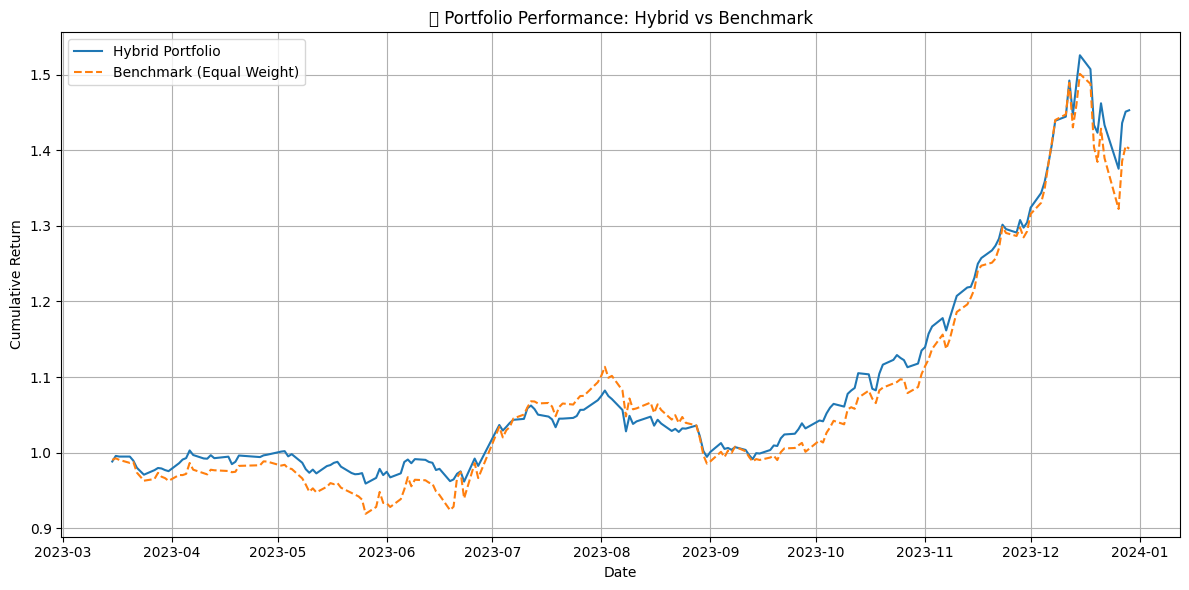

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(hybrid_cumulative, label='Hybrid Portfolio')
plt.plot(benchmark_cumulative, label='Benchmark (Equal Weight)', linestyle='--')
plt.title('📈 Portfolio Performance: Hybrid vs Benchmark')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# -------------------- Step 11: Sharpe Ratio Comparison -------------------- #
def calculate_sharpe(port_returns, risk_free_rate=0.0):
    excess_returns = port_returns - risk_free_rate
    return (excess_returns.mean() / excess_returns.std()) * np.sqrt(252)  # Annualized

hybrid_sharpe = calculate_sharpe(hybrid_port_returns)
benchmark_sharpe = calculate_sharpe(benchmark_returns)

print(f"\n⚖️ Sharpe Ratio Comparison:")
print(f"Hybrid Portfolio Sharpe Ratio:   {hybrid_sharpe:.4f}")
print(f"Benchmark (Equal Weight):        {benchmark_sharpe:.4f}")


⚖️ Sharpe Ratio Comparison:
Hybrid Portfolio Sharpe Ratio:   2.6444
Benchmark (Equal Weight):        1.9880


<ipython-input-94-58654deae4c5>:8: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


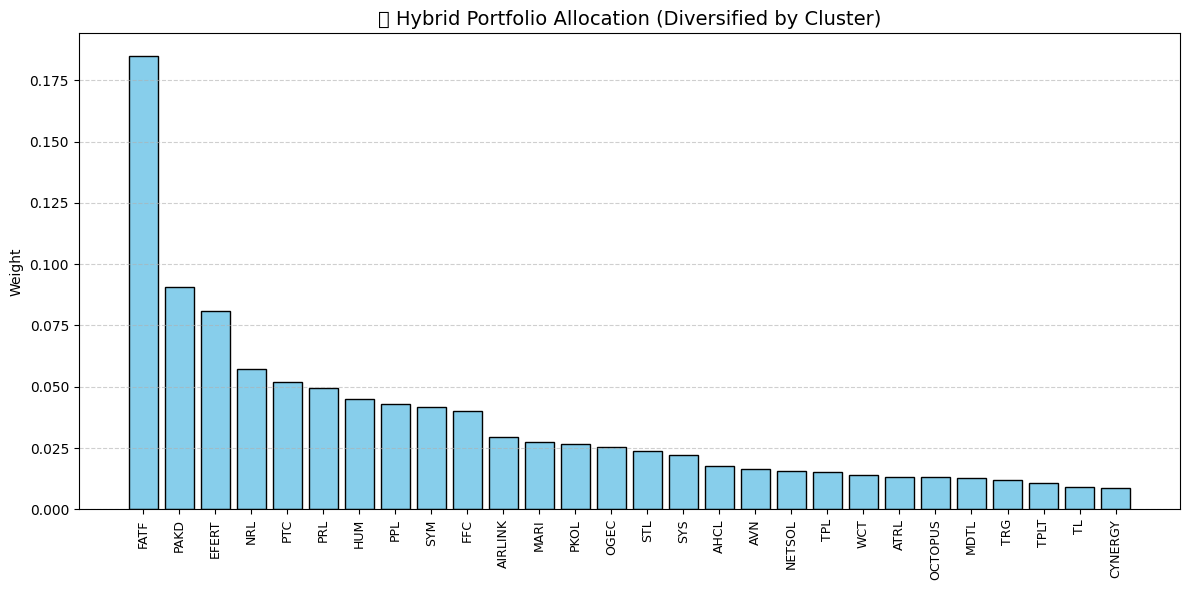

In [ ]:
# Step 11: Portfolio Allocation Plot
plt.figure(figsize=(12, 6))
plt.bar(portfolio['Company'], portfolio['Final_Weight'], color='skyblue', edgecolor='black')
plt.xticks(rotation=90, fontsize=9)
plt.title('📊 Hybrid Portfolio Allocation (Diversified by Cluster)', fontsize=14)
plt.ylabel('Weight')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

<ipython-input-95-c59a1a505280>:10: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


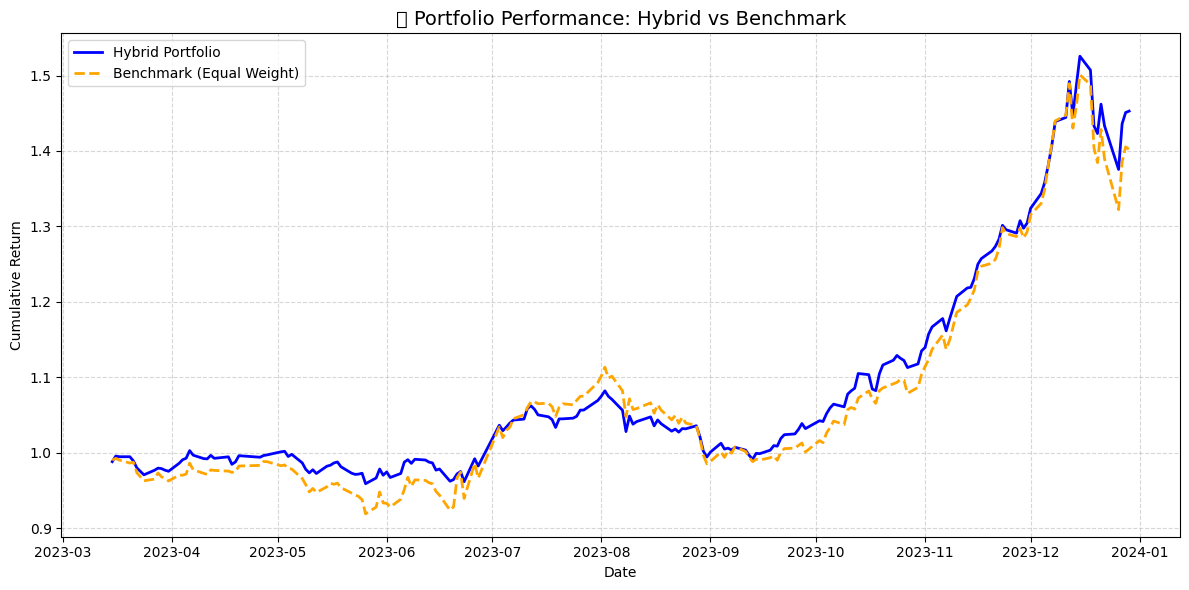

In [ ]:
# Step 12: Cumulative Performance Plot
plt.figure(figsize=(12, 6))
plt.plot(hybrid_cumulative, label='Hybrid Portfolio', color='blue', linewidth=2)
plt.plot(benchmark_cumulative, label='Benchmark (Equal Weight)', linestyle='--', color='orange', linewidth=2)
plt.title('📈 Portfolio Performance: Hybrid vs Benchmark', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
# Step 13: Performance Metrics
portfolio_mean = hybrid_port_returns.mean()
portfolio_std = hybrid_port_returns.std()
benchmark_mean = benchmark_returns.mean()
benchmark_std = benchmark_returns.std()

sharpe_portfolio = portfolio_mean / portfolio_std
sharpe_benchmark = benchmark_mean / benchmark_std

print("\n📊 Performance Metrics Comparison:")
print("----------------------------------")
print(f"📘 Hybrid Portfolio Mean Return   : {portfolio_mean:.4f}")
print(f"📘 Hybrid Portfolio Std Dev       : {portfolio_std:.4f}")
print(f"📘 Hybrid Portfolio Sharpe Ratio  : {sharpe_portfolio:.4f}")
print()
print(f"📙 Benchmark Mean Return          : {benchmark_mean:.4f}")
print(f"📙 Benchmark Std Dev              : {benchmark_std:.4f}")
print(f"📙 Benchmark Sharpe Ratio         : {sharpe_benchmark:.4f}")


📊 Performance Metrics Comparison:
----------------------------------
📘 Hybrid Portfolio Mean Return   : 0.0020
📘 Hybrid Portfolio Std Dev       : 0.0120
📘 Hybrid Portfolio Sharpe Ratio  : 0.1666

📙 Benchmark Mean Return          : 0.0019
📙 Benchmark Std Dev              : 0.0148
📙 Benchmark Sharpe Ratio         : 0.1252


<ipython-input-97-b8258327c618>:5: UserWarning: Glyph 128280 (\N{RADIO BUTTON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128280 (\N{RADIO BUTTON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


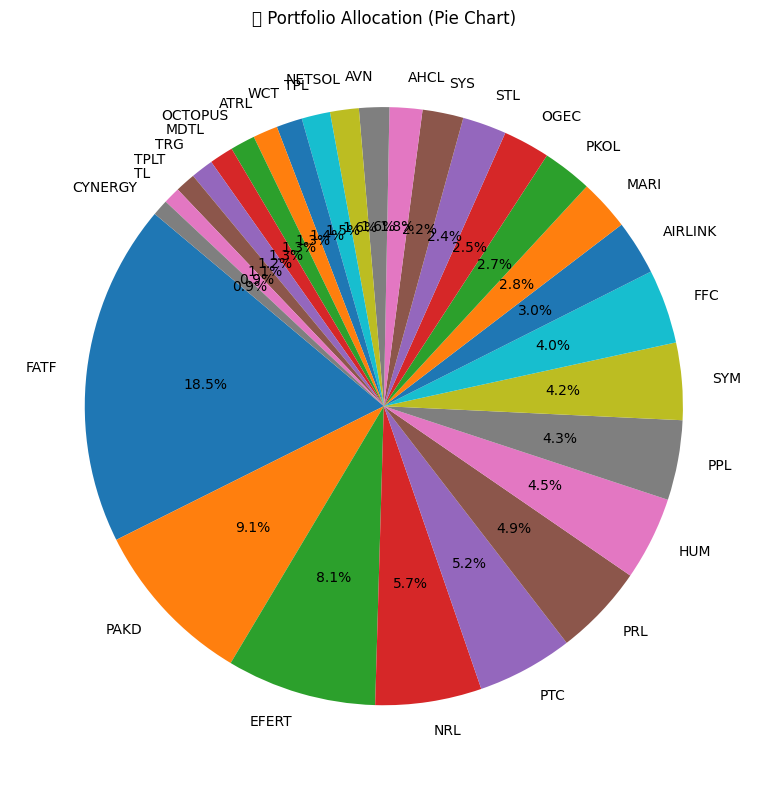

In [ ]:
# Pie chart
plt.figure(figsize=(8, 8))
plt.pie(portfolio['Final_Weight'], labels=portfolio['Company'], autopct='%1.1f%%', startangle=140)
plt.title('🔘 Portfolio Allocation (Pie Chart)')
plt.tight_layout()
plt.show()


<ipython-input-98-bcb2a0db0675>:9: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


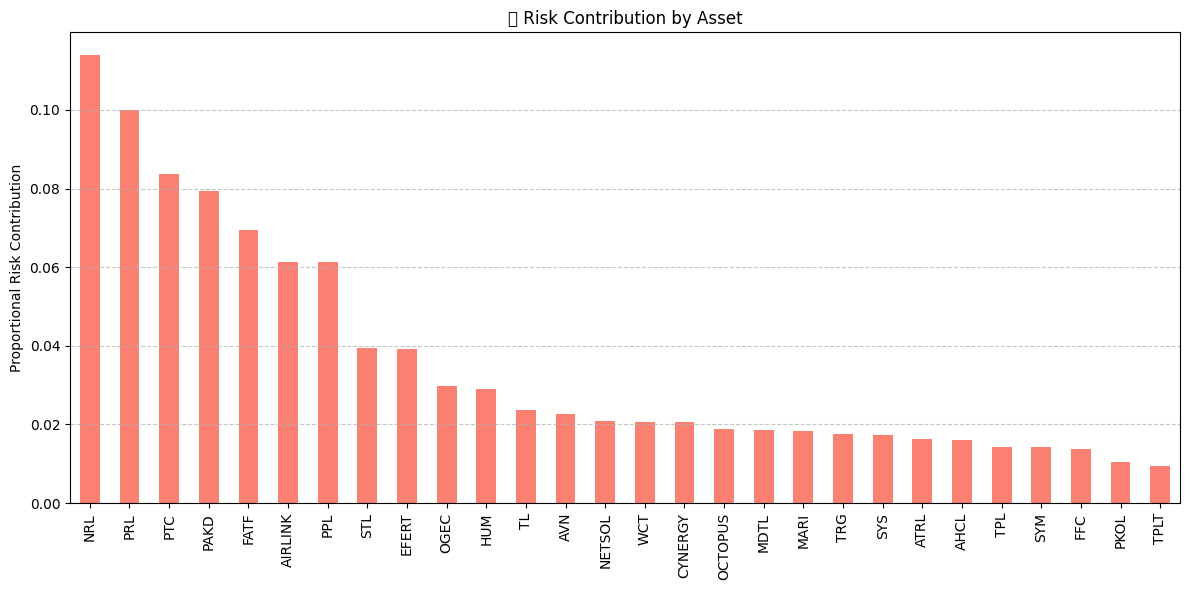

In [ ]:
# Risk contribution = weight * (cov_matrix @ weights)
risk_contrib = hybrid_weights_series * (cov_matrix @ hybrid_weights_series)
risk_contrib /= risk_contrib.sum()

# Plot
risk_contrib.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6), color='salmon', title='📉 Risk Contribution by Asset')
plt.ylabel('Proportional Risk Contribution')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


<ipython-input-99-32765a5388db>:10: UserWarning: Glyph 128315 (\N{DOWN-POINTING RED TRIANGLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128315 (\N{DOWN-POINTING RED TRIANGLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


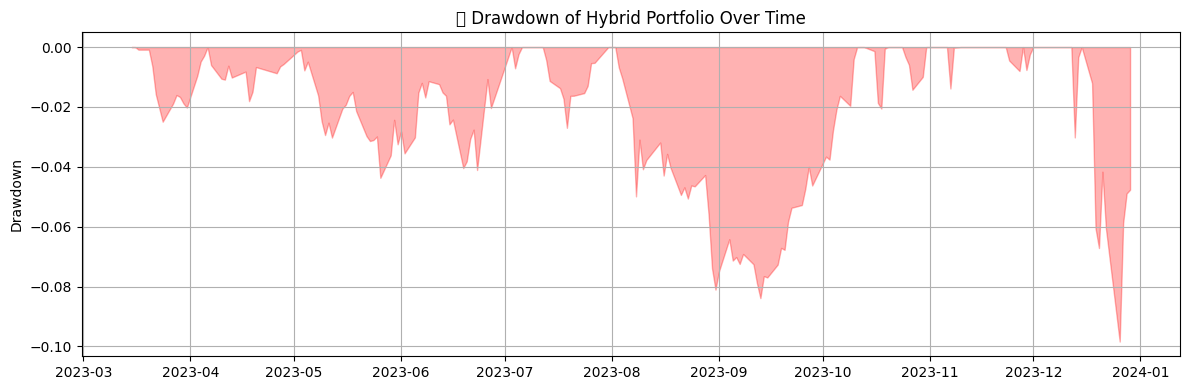

In [ ]:
# Drawdown
rolling_max = hybrid_cumulative.cummax()
drawdown = (hybrid_cumulative - rolling_max) / rolling_max

plt.figure(figsize=(12, 4))
plt.fill_between(drawdown.index, drawdown, color='red', alpha=0.3)
plt.title('🔻 Drawdown of Hybrid Portfolio Over Time')
plt.ylabel('Drawdown')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
metrics_df = pd.DataFrame({
    'Metric': ['Mean Return', 'Std Deviation', 'Sharpe Ratio'],
    'Hybrid Portfolio': [portfolio_mean, portfolio_std, sharpe_portfolio],
    'Benchmark': [benchmark_mean, benchmark_std, sharpe_benchmark]
})

print(metrics_df.to_string(index=False))


       Metric  Hybrid Portfolio  Benchmark
  Mean Return          0.001999   0.001852
Std Deviation          0.011999   0.014785
 Sharpe Ratio          0.166583   0.125235


In [ ]:
import pandas as pd
import numpy as np

# ------------------ Step 1: Load predicted prices ------------------ #
data = pd.read_csv('PPS (2).csv', index_col=0, parse_dates=True)
returns = data.pct_change().dropna()
returns.columns = returns.columns.str.upper()

# ------------------ Step 2: Prepare hybrid weights ------------------ #
# Assuming 'hybrid_weights_df' already exists from earlier steps
hybrid_weights_df['Company'] = hybrid_weights_df['Company'].str.upper()

# Ensure companies match
common_companies = list(set(returns.columns) & set(hybrid_weights_df['Company']))

# Filter to only common companies
returns = returns[common_companies]
hybrid_weights_df = hybrid_weights_df[hybrid_weights_df['Company'].isin(common_companies)]

# Normalize weights again (just in case)
weights_series = hybrid_weights_df.set_index('Company')['Final_Weight']
weights_series = weights_series.loc[common_companies]
weights_series /= weights_series.sum()

# ------------------ Step 3: Compute asset-level stats ------------------ #
asset_means = returns.mean()
asset_stds = returns.std()
asset_sharpes = asset_means / asset_stds

# ------------------ Step 4: Build table ------------------ #
summary_table = pd.DataFrame({
    'Daily Return': asset_means,
    'Risk (Std Dev)': asset_stds,
    'Sharpe Ratio': asset_sharpes,
    'Weight': weights_series
})

summary_table = summary_table.round(4)
summary_table = summary_table.sort_values(by='Weight', ascending=False)

# ------------------ Step 5: Display / Export ------------------ #
print("\n📊 Asset-Level Portfolio Summary:\n")
print(summary_table.to_string())

# Optional: Save to CSV or Excel
summary_table.to_csv("hybrid_portfolio_asset_stats.csv")



📊 Asset-Level Portfolio Summary:

Empty DataFrame
Columns: [Daily Return, Risk (Std Dev), Sharpe Ratio, Weight]
Index: []


<ipython-input-104-13795fcb19ed>:6: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()
